Main Research Question 2:

* How do organizational communication networks and sentiment in communications influence employee turnover?

Subquestions for Main Research Question 2:

* How does an employee's position within the organizational communication network affect their risk of turnover?

* How does the sentiment expressed in an employee's communications impact their likelihood of leaving?

# Set Up

In [ ]:
# Install essential libraries
!pip install --upgrade scikit-learn  # For machine learning models
!pip install --upgrade networkx      # For network graph analysis
!pip install --upgrade node2vec      # For graph embeddings

# Install for network community detection (only if needed)
!pip install python-louvain


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 95.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


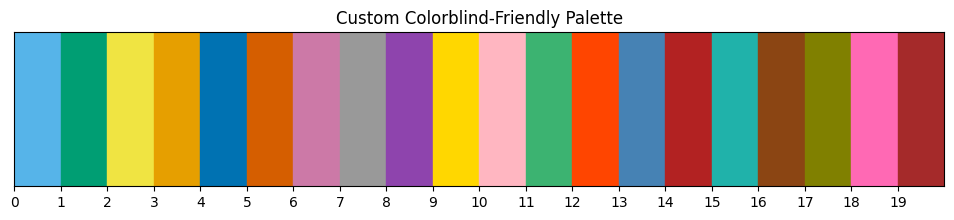

In [ ]:
# For network analysis
import networkx as nx
from node2vec import Node2Vec
import networkx as nx
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from scipy.stats import chi2_contingency
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind, mannwhitneyu
from community import community_louvain

# For data manipulation
import pandas as pd
import numpy as np

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler

# Set default figure size for plots
plt.rcParams['figure.figsize'] = (10, 6)

# Set the default color cycle for matplotlib with a colorblind-friendly palette
color_palette = [
    "#56B4E9",  # sky blue
    "#009E73",  # green
    "#F0E442",  # yellow
    "#E69F00",  # orange
    "#0072B2",  # blue
    "#D55E00",  # red-orange
    "#CC79A7",  # pink
    "#999999",  # grey
    "#8E44AD",  # purple
    "#FFD700",  # gold
    "#FFB6C1",  # light pink
    "#3CB371",  # medium sea green
    "#FF4500",  # orange-red
    "#4682B4",  # steel blue
    "#B22222",  # firebrick
    "#20B2AA",  # light sea green
    "#8B4513",  # saddle brown
    "#808000",  # olive
    "#FF69B4",  # hot pink
    "#A52A2A",  # brown
]

plt.rcParams['axes.prop_cycle'] = cycler(color=color_palette)

# Plot a test to visualize the colors
fig, ax = plt.subplots(figsize=(12, 2))
for i, color in enumerate(color_palette):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
ax.set_xlim(0, len(color_palette))
ax.set_yticks([])
ax.set_xticks(range(len(color_palette)))
plt.title("Custom Colorblind-Friendly Palette")
plt.show()

In [ ]:
# Command to display NVIDIA GPU status, including memory usage and processes utilizing the GPU
!nvidia-smi

Wed Jan 15 15:09:40 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0              43W / 350W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.17.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Datasets

In [ ]:
# Define the path to your CSV file
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/TT/DATA/final_comment.csv'

# Read the CSV file without using 'date_parser' and without parsing dates initially
comments = pd.read_csv(
    csv_file_path,
    dtype={'comment_like_count': 'int64'},  # Define data type for specific columns
    parse_dates=False                        # Do not parse dates during reading
)

# Convert 'comment_created_date' to datetime with dayfirst=True
comments['comment_created_date'] = pd.to_datetime(
    comments['comment_created_date'],
    dayfirst=True,
    errors='coerce'  # Optional: Handle parsing errors by setting invalid parsing as NaT
)

# Display the DataFrame information to verify successful loading and parsing
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587199 entries, 0 to 587198
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   stream_name             587199 non-null  object        
 1   post_id                 587199 non-null  object        
 2   post_title              587199 non-null  object        
 3   comment_created_date    587199 non-null  datetime64[ns]
 4   comment_id              587199 non-null  object        
 5   userid                  587199 non-null  object        
 6   username                587199 non-null  object        
 7   comment_text            587199 non-null  object        
 8   comment_like_count      587199 non-null  int64         
 9   cleaned_comment_text    587199 non-null  object        
 10  comment_text_sentiment  587199 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 49.3+ MB


In [ ]:
# Read the CSV file
posts= pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/TT/DATA/final_post.csv',
    parse_dates=['post_created_date'], dtype={'post_like_count': 'int64', 'post_comment_count': 'int64'}
)

posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203955 entries, 0 to 203954
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   stream_name           203955 non-null  object        
 1   stream_id             203955 non-null  object        
 2   post_id               203955 non-null  object        
 3   userid                203955 non-null  object        
 4   post_created_date     203955 non-null  datetime64[ns]
 5   post_like_count       203955 non-null  int64         
 6   post_comment_count    203955 non-null  int64         
 7   cleaned_post_text     203955 non-null  object        
 8   post_text_sentiment   203955 non-null  object        
 9   cleaned_post_title    168912 non-null  object        
 10  post_title_sentiment  168912 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 17.1+ MB


In [ ]:
# Read the CSV file
users = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/TT/DATA/user_cleaned.csv',
    parse_dates=[
        'first_login', 'last_login', 'updated', 'used', 'suspended_at', 'created'  # Columns to parse as datetime
    ],
    dtype={
        'suspended': 'bool',                 # Boolean column
        'stream_id': 'object',              # Float column for IDs or numeric values
        'userid': 'object',                  # User ID as string
        'org_unit_id': 'object',             # Organizational unit ID as string
        'display_name_extension': 'object',  # String column for name extensions
        'position': 'object',                # Position as string
        'country': 'object',                 # Country as string
        'total_of_departments': 'int64',     # Integer column for department counts
        'total_of_jobs': 'int64'             # Integer column for job counts
    }
)

# Display DataFrame information to confirm correct parsing
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151632 entries, 0 to 151631
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   first_login             63468 non-null   datetime64[ns]
 1   suspended               151632 non-null  bool          
 2   stream_id               151632 non-null  object        
 3   userid                  151632 non-null  object        
 4   org_unit_id             151632 non-null  object        
 5   last_login              63468 non-null   datetime64[ns]
 6   updated                 151632 non-null  datetime64[ns]
 7   used                    63464 non-null   datetime64[ns]
 8   display_name_extension  151632 non-null  object        
 9   suspended_at            76809 non-null   datetime64[ns]
 10  created                 151632 non-null  datetime64[ns]
 11  position                151632 non-null  object        
 12  country                 151632

# Sentiment Analysis

In [ ]:
# Sentiments in posts
print("\nSentiment distribution in the text of posts:")
print(posts['post_text_sentiment'].value_counts())

# Sentiments in titles
print("\nSentiment distribution in the title of posts(including missing):")
print(posts['post_title_sentiment'].fillna('missing').value_counts())

# Sentiments in comments
print("\nSentiment distribution in the text of comments:")
print(comments['comment_text_sentiment'].value_counts())


Sentiment distribution in the text of posts:
post_text_sentiment
positive    151482
neutral      45568
negative      6905
Name: count, dtype: int64

Sentiment distribution in the title of posts(including missing):
post_title_sentiment
neutral     109527
positive     55839
missing      35043
negative      3546
Name: count, dtype: int64

Sentiment distribution in the text of comments:
comment_text_sentiment
positive    510625
neutral      71101
negative      5473
Name: count, dtype: int64


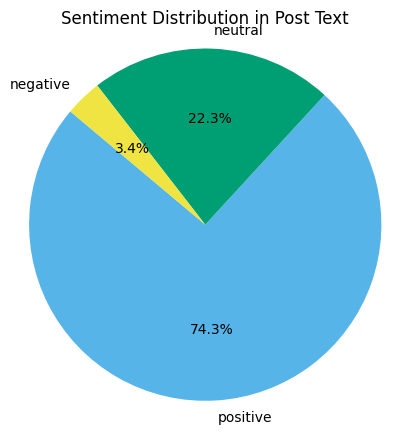

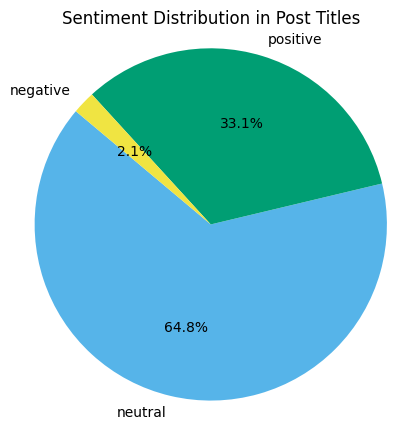

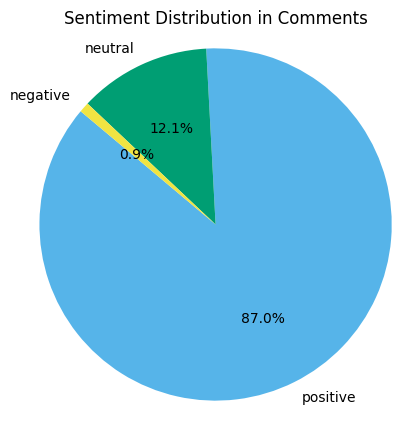

In [ ]:
def plot_sentiment_pie(data, column, title):
    # Aggregate sentiment categories
    sentiment_counts = data[column].value_counts()
    labels = sentiment_counts.index
    sizes = sentiment_counts.values

    # Create a pie chart
    plt.figure(figsize=(5, 5))  # Small pie chart size
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 10})
    plt.title(title, fontsize=12)
    plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
    plt.show()

# Plot sentiment pie charts
plot_sentiment_pie(posts, 'post_text_sentiment', 'Sentiment Distribution in Post Text')
plot_sentiment_pie(posts, 'post_title_sentiment', 'Sentiment Distribution in Post Titles')
plot_sentiment_pie(comments, 'comment_text_sentiment', 'Sentiment Distribution in Comments')

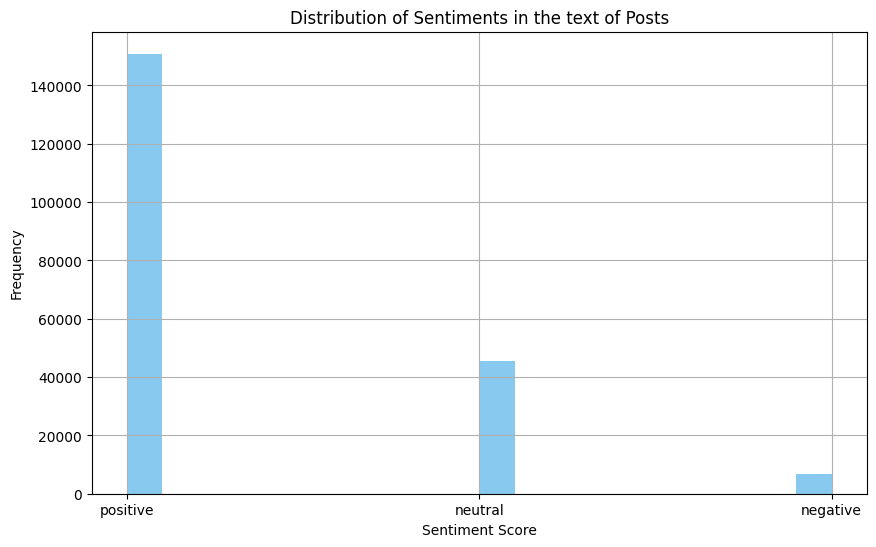

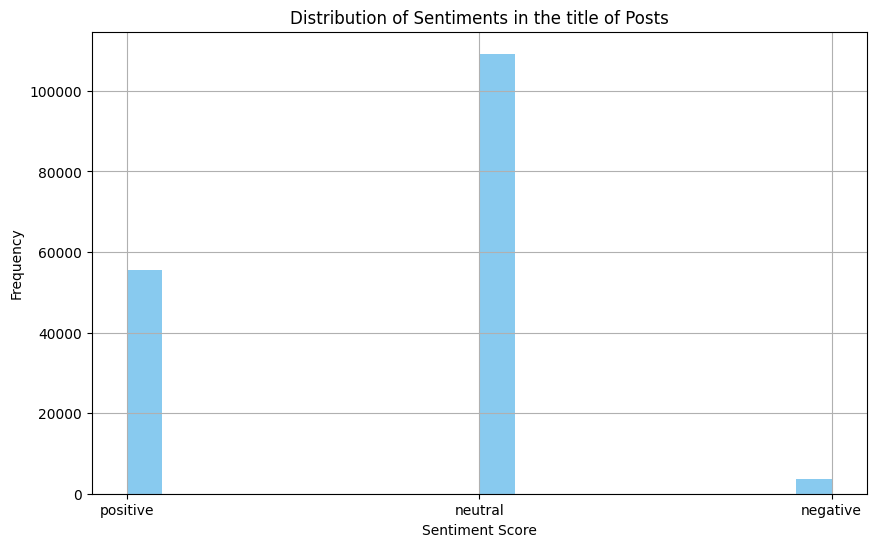

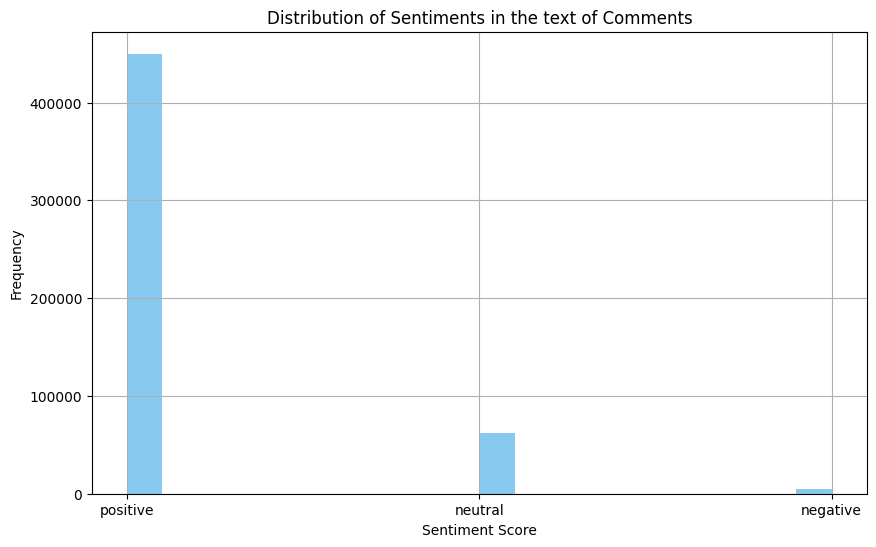

In [ ]:
# Define a function for plotting histograms
def plot_sentiment_histogram(data, column, title, xlabel, ylabel):
    data[column].hist(bins=20, alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Plot sentiment histograms
plot_sentiment_histogram(posts, 'post_text_sentiment', 'Distribution of Sentiments in the text of Posts', 'Sentiment Score', 'Frequency')
plot_sentiment_histogram(posts, 'post_title_sentiment', 'Distribution of Sentiments in the title of Posts', 'Sentiment Score', 'Frequency')
plot_sentiment_histogram(comments, 'comment_text_sentiment', 'Distribution of Sentiments in the text of Comments', 'Sentiment Score', 'Frequency')

In [ ]:
# Map sentiments to numerical values
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
posts['post_text_sentiment_score'] = posts['post_text_sentiment'].map(sentiment_map)
comments['comment_text_sentiment_score'] = comments['comment_text_sentiment'].map(sentiment_map)
posts['post_title_sentiment_score'] = posts['post_title_sentiment'].map(sentiment_map)

# Calculate the mean of post title sentiment scores (ignoring null values)
mean_title_sentiment = posts['post_title_sentiment_score'].mean()

# Replace null values in post title sentiment scores with the mean
posts['post_title_sentiment_score'] = posts['post_title_sentiment_score'].fillna(mean_title_sentiment)

# Descriptive summary
print("\nDescriptive metrics - Sentiments in the text of posts:")
print(posts['post_text_sentiment_score'].describe())

print("\nDescriptive metrics - Sentiments in the title of posts (after imputing mean):")
print(posts['post_title_sentiment_score'].describe())

print("\nDescriptive metrics - Sentiments in the text of comments:")
print(comments['comment_text_sentiment_score'].describe())



Descriptive metrics - Sentiments in the text of posts:
count    203231.000000
mean          0.708558
std           0.523746
min          -1.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: post_text_sentiment_score, dtype: float64

Descriptive metrics - Sentiments in the title of posts (after imputing mean):
count    203231.000000
mean          0.308992
std           0.460084
min          -1.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: post_title_sentiment_score, dtype: float64

Descriptive metrics - Sentiments in the text of comments:
count    516462.000000
mean          0.861554
std           0.371935
min          -1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: comment_text_sentiment_score, dtype: float64


In [ ]:
# Calculate average sentiment scores per user
post_text_sentiment_avg = posts.groupby('userid')['post_text_sentiment_score'].mean().reset_index(name='average_post_text_sentiment')
post_title_sentiment_avg = posts.groupby('userid')['post_title_sentiment_score'].mean().reset_index(name='average_post_title_sentiment')
comment_text_sentiment_avg = comments.groupby('userid')['comment_text_sentiment_score'].mean().reset_index(name='average_comment_text_sentiment')

# Merge with the users dataset
users_sentiment = users.merge(post_text_sentiment_avg, on='userid', how='left')
users_sentiment = users_sentiment.merge(post_title_sentiment_avg, on='userid', how='left')
users_sentiment = users_sentiment.merge(comment_text_sentiment_avg, on='userid', how='left')

# Filter users into groups based on the availability of sentiment data
group_post_text = users_sentiment[~users_sentiment['average_post_text_sentiment'].isna()]
group_post_title = users_sentiment[~users_sentiment['average_post_title_sentiment'].isna()]
group_comment_text = users_sentiment[~users_sentiment['average_comment_text_sentiment'].isna()]

# Descriptive summary for each group
print("\nDescriptive metrics - Average post text sentiment by user:")
print(group_post_text['average_post_text_sentiment'].describe())

print("\nDescriptive metrics - Average post title sentiment by user:")
print(group_post_title['average_post_title_sentiment'].describe())

print("\nDescriptive metrics - Average comment text sentiment by user:")
print(group_comment_text['average_comment_text_sentiment'].describe())




Descriptive metrics - Average post text sentiment by user:
count    10652.000000
mean         0.687564
std          0.408844
min         -1.000000
25%          0.500000
50%          0.906250
75%          1.000000
max          1.000000
Name: average_post_text_sentiment, dtype: float64

Descriptive metrics - Average post title sentiment by user:
count    10652.000000
mean         0.322028
std          0.321898
min         -1.000000
25%          0.047194
50%          0.308992
75%          0.477107
max          1.000000
Name: average_post_title_sentiment, dtype: float64

Descriptive metrics - Average comment text sentiment by user:
count    17188.000000
mean         0.803410
std          0.321884
min         -1.000000
25%          0.741935
50%          0.979852
75%          1.000000
max          1.000000
Name: average_comment_text_sentiment, dtype: float64



Grouped Sentiment Averages by Suspension Status (Filtered Groups):
   suspended  Post Text Sentiment  Post Title Sentiment  \
0      False             0.704887              0.327885   
1       True             0.611598              0.296346   

   Comment Text Sentiment  
0                0.803577  
1                0.802546  


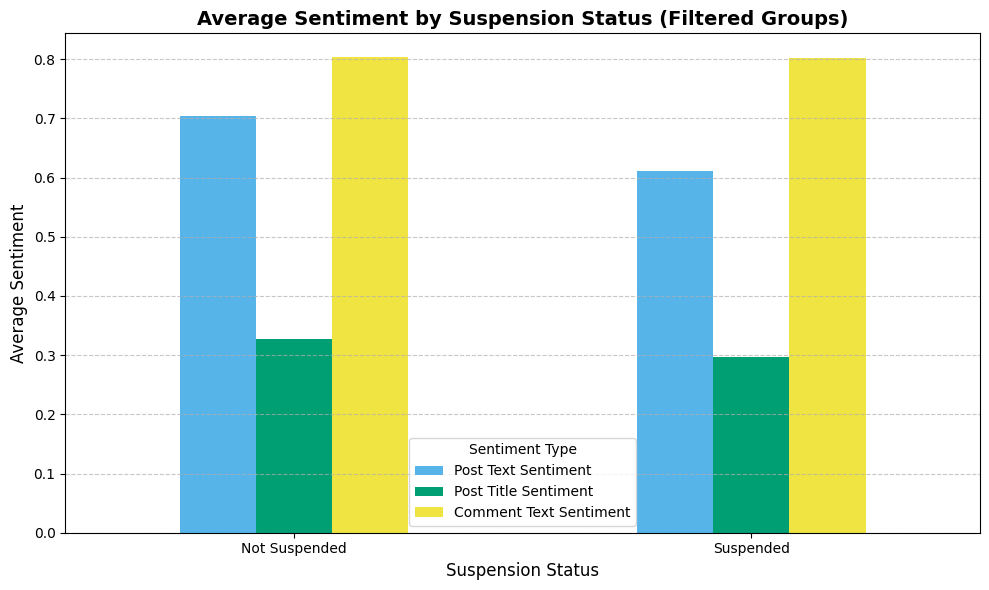

In [ ]:
# Calculate averages by group (Suspended vs. Not Suspended) for each filtered group
grouped_post_text = group_post_text.groupby('suspended')['average_post_text_sentiment'].mean()
grouped_post_title = group_post_title.groupby('suspended')['average_post_title_sentiment'].mean()
grouped_comment_text = group_comment_text.groupby('suspended')['average_comment_text_sentiment'].mean()

# Combine the grouped data into a single DataFrame for easier visualization
grouped_sentiment = pd.DataFrame({
    'Post Text Sentiment': grouped_post_text,
    'Post Title Sentiment': grouped_post_title,
    'Comment Text Sentiment': grouped_comment_text
}).reset_index()

# Verify the structure of grouped_sentiment
print("\nGrouped Sentiment Averages by Suspension Status (Filtered Groups):")
print(grouped_sentiment)

# Create a bar chart
grouped_sentiment.set_index('suspended').plot(
    kind='bar',
    figsize=(10, 6)
)

# Add titles and labels
plt.title('Average Sentiment by Suspension Status (Filtered Groups)', fontsize=14, fontweight='bold')
plt.xlabel('Suspension Status', fontsize=12)
plt.ylabel('Average Sentiment', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Not Suspended', 'Suspended'], rotation=0, fontsize=10)
plt.legend(
    title='Sentiment Type',
    fontsize=10
)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the chart
plt.tight_layout()
plt.show()



Average Sentiment Scores by Suspension Status (Filtered Groups):
   suspended  Post Text Sentiment  Post Title Sentiment  \
0      False             0.704887              0.327885   
1       True             0.611598              0.296346   

   Comment Text Sentiment  
0                0.803577  
1                0.802546  


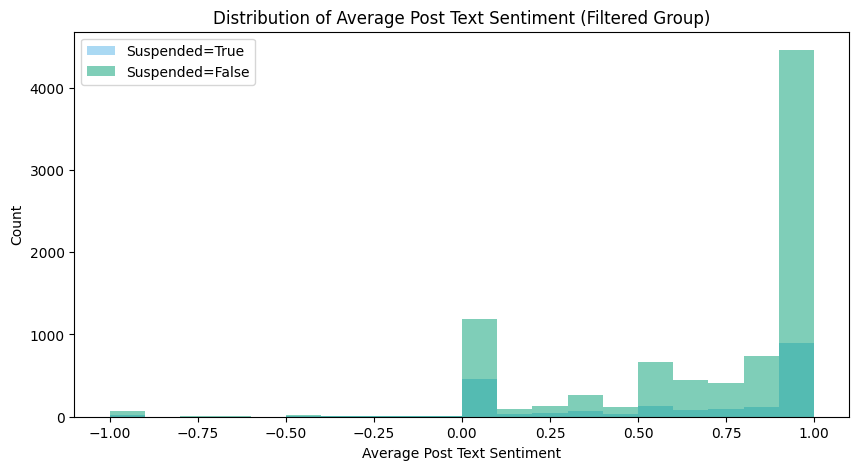

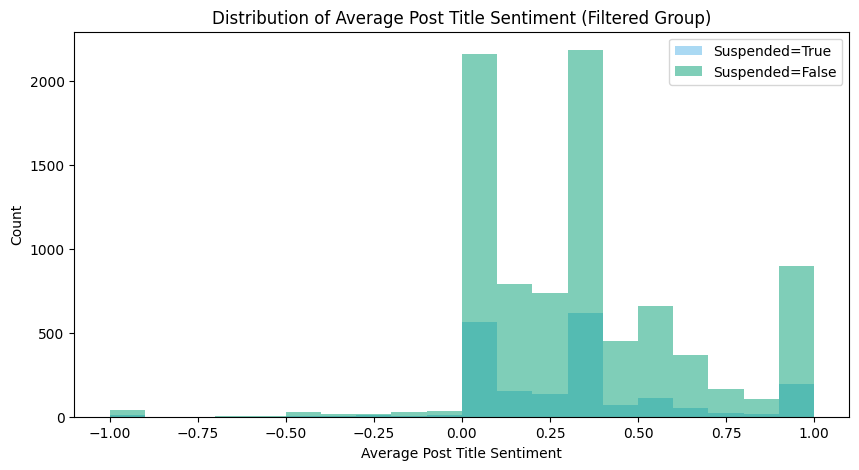

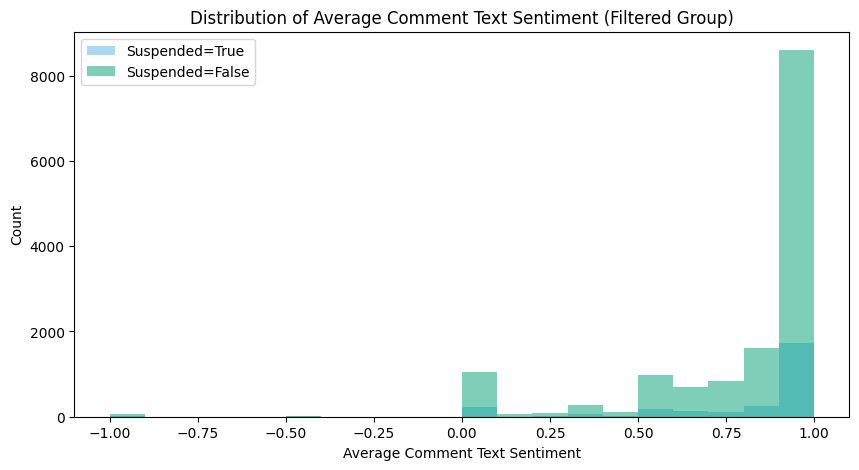

In [ ]:
# Calculate average sentiment scores for suspended and non-suspended users for each filtered group
grouped_post_text = group_post_text.groupby('suspended')['average_post_text_sentiment'].mean()
grouped_post_title = group_post_title.groupby('suspended')['average_post_title_sentiment'].mean()
grouped_comment_text = group_comment_text.groupby('suspended')['average_comment_text_sentiment'].mean()

# Combine the grouped data into a single DataFrame for easier interpretation
grouped_sentiment = pd.DataFrame({
    'Post Text Sentiment': grouped_post_text,
    'Post Title Sentiment': grouped_post_title,
    'Comment Text Sentiment': grouped_comment_text
}).reset_index()

print("\nAverage Sentiment Scores by Suspension Status (Filtered Groups):")
print(grouped_sentiment)

# Distribution of sentiment scores (histograms)
# Post text sentiments
plt.figure(figsize=(10, 5))
for suspended in [True, False]:
    subset = group_post_text[group_post_text['suspended'] == suspended]
    plt.hist(
        subset['average_post_text_sentiment'],
        bins=20, alpha=0.5, label=f'Suspended={suspended}'
    )
plt.xlabel('Average Post Text Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Average Post Text Sentiment (Filtered Group)')
plt.legend()
plt.show()

# Post title sentiments
plt.figure(figsize=(10, 5))
for suspended in [True, False]:
    subset = group_post_title[group_post_title['suspended'] == suspended]
    plt.hist(
        subset['average_post_title_sentiment'],
        bins=20, alpha=0.5, label=f'Suspended={suspended}'
    )
plt.xlabel('Average Post Title Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Average Post Title Sentiment (Filtered Group)')
plt.legend()
plt.show()

# Comment text sentiments
plt.figure(figsize=(10, 5))
for suspended in [True, False]:
    subset = group_comment_text[group_comment_text['suspended'] == suspended]
    plt.hist(
        subset['average_comment_text_sentiment'],
        bins=20, alpha=0.5, label=f'Suspended={suspended}'
    )
plt.xlabel('Average Comment Text Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Average Comment Text Sentiment (Filtered Group)')
plt.legend()
plt.show()


In [ ]:
# T-test for post text sentiments
suspended_post_text = group_post_text[group_post_text['suspended'] == True]['average_post_text_sentiment']
not_suspended_post_text = group_post_text[group_post_text['suspended'] == False]['average_post_text_sentiment']
t_stat_post_text, p_val_post_text = ttest_ind(suspended_post_text, not_suspended_post_text, equal_var=False)
print(f"Post Text Sentiment - t-stat: {t_stat_post_text}, p-value: {p_val_post_text}")

# T-test for post title sentiments
suspended_post_title = group_post_title[group_post_title['suspended'] == True]['average_post_title_sentiment']
not_suspended_post_title = group_post_title[group_post_title['suspended'] == False]['average_post_title_sentiment']
t_stat_post_title, p_val_post_title = ttest_ind(suspended_post_title, not_suspended_post_title, equal_var=False)
print(f"Post Title Sentiment - t-stat: {t_stat_post_title}, p-value: {p_val_post_title}")

# T-test for comment text sentiments
suspended_comments = group_comment_text[group_comment_text['suspended'] == True]['average_comment_text_sentiment']
not_suspended_comments = group_comment_text[group_comment_text['suspended'] == False]['average_comment_text_sentiment']
t_stat_comment, p_val_comment = ttest_ind(suspended_comments, not_suspended_comments, equal_var=False)
print(f"Comment Text Sentiment - t-stat: {t_stat_comment}, p-value: {p_val_comment}")


Post Text Sentiment - t-stat: -8.609797285555075, p-value: 1.2104722634873317e-17
Post Title Sentiment - t-stat: -3.980490721072943, p-value: 7.04115535402579e-05
Comment Text Sentiment - t-stat: -0.15015864959836317, p-value: 0.8806473715314311


* **Post Text Sentiment:**
Result: Significant difference in average sentiment between suspended and non-suspended users.
Finding: Suspended users have a lower average post text sentiment than non-suspended users. This indicates that users with more negative posts are more likely to be suspended. **Evidence:** t-stat = -8.61, p-value = 1.21e-17 (highly significant).

* **Post Title Sentiment:**
Result: Significant difference in average sentiment between suspended and non-suspended users.
Finding: Suspended users have a slightly lower average post title sentiment than non-suspended users, suggesting a weaker but still notable association. **Evidence**: t-stat = -3.98, p-value = 7.04e-05 (significant).

* **Comment Text Sentiment:**
Result: No significant difference in average sentiment between suspended and non-suspended users.
Finding: Sentiment in comments does not show a meaningful relationship with suspension status **Evidence:** t-stat = -0.15, p-value = 0.88 (not significant).

## Chi-Square Test

Post Text Sentiment - Chi2: 106.94, p-value: 0.00000 (significant)
Post Title Sentiment - Chi2: 14.55, p-value: 0.00069 (significant)
Comment Text Sentiment - Chi2: 3.62, p-value: 0.16393 (not significant)

Contingency Table (Post Text Sentiment):
post_text_category  negative  neutral  positive
suspended                                      
False                    141     1139      7394
True                      40      438      1500

Expected Frequencies (Post Text Sentiment):
[[ 147.3895982  1284.16241081 7242.44799099]
 [  33.6104018   292.83758919 1651.55200901]]

Contingency Table (Post Title Sentiment):
post_title_category  negative  neutral  positive
suspended                                       
False                     171     1822      6681
True                       43      491      1444

Expected Frequencies (Post Title Sentiment):
[[ 174.26173489 1883.49248967 6616.24577544]
 [  39.73826511  429.50751033 1508.75422456]]

Contingency Table (Comment Text Sentiment):
com

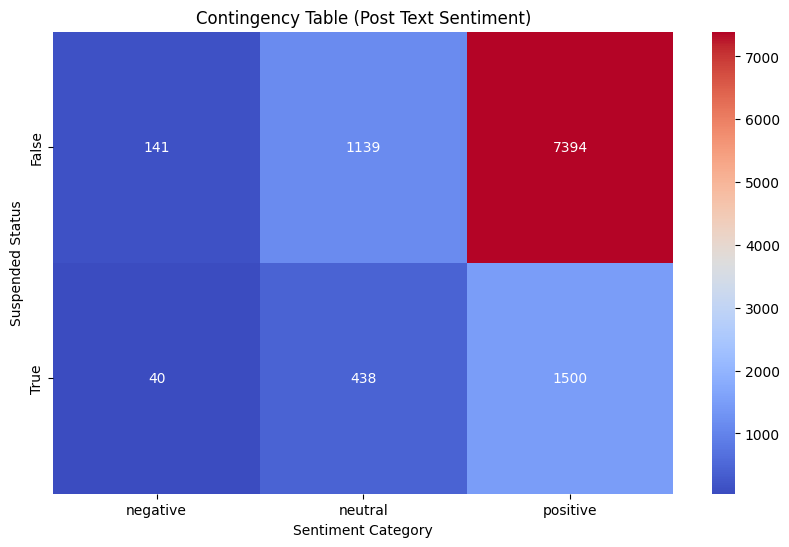

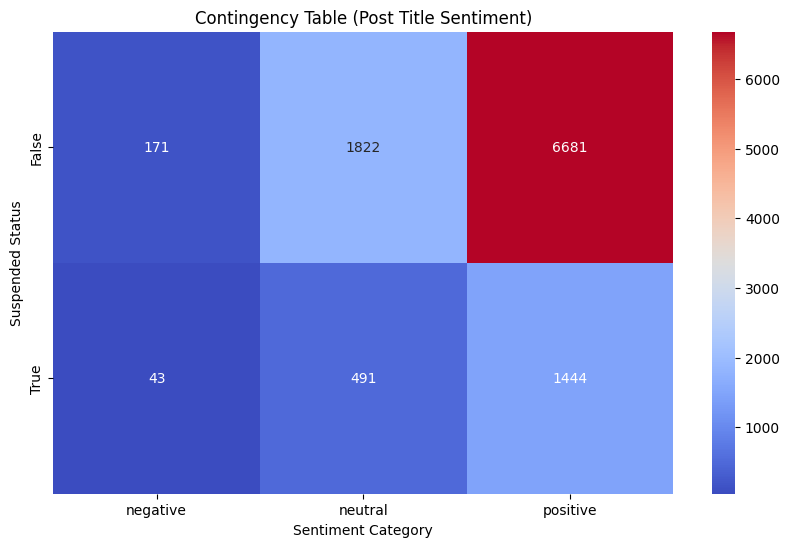

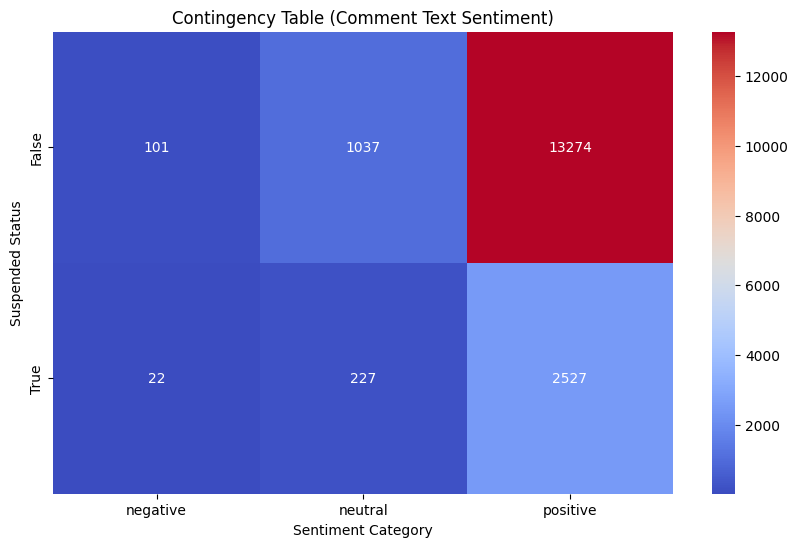

In [ ]:
# Define a function for categorizing sentiment
def categorize_sentiment(score):
    if score > 0:
        return 'positive'
    elif score == 0:
        return 'neutral'
    else:
        return 'negative'

# Apply sentiment categorization for different groups
group_post_text['post_text_category'] = group_post_text['average_post_text_sentiment'].apply(categorize_sentiment)
group_post_title['post_title_category'] = group_post_title['average_post_title_sentiment'].apply(categorize_sentiment)
group_comment_text['comment_text_category'] = group_comment_text['average_comment_text_sentiment'].apply(categorize_sentiment)

# Display Chi-square results
def display_chi_square_results(results):
    for name, chi2, p in results:
        significance = "significant" if p < 0.05 else "not significant"
        print(f"{name} - Chi2: {chi2:.2f}, p-value: {p:.5f} ({significance})")

# Calculate and store Chi-square results
results = [
    ("Post Text Sentiment", chi2_stat_post_text, p_val_post_text),
    ("Post Title Sentiment", chi2_stat_post_title, p_val_post_title),
    ("Comment Text Sentiment", chi2_stat_comment_text, p_val_comment_text),
]
display_chi_square_results(results)

# Display contingency tables and expected frequencies
def display_contingency_and_expected(table, expected, title):
    print(f"\nContingency Table ({title}):")
    print(table)
    print(f"\nExpected Frequencies ({title}):")
    print(expected)

display_contingency_and_expected(contingency_post_text, expected_post_text, "Post Text Sentiment")
display_contingency_and_expected(contingency_post_title, expected_post_title, "Post Title Sentiment")
display_contingency_and_expected(contingency_comment_text, expected_comment_text, "Comment Text Sentiment")

# Plot heatmaps for contingency tables
def plot_heatmap(contingency_table, title):
    sns.heatmap(contingency_table, annot=True, fmt="d", cmap="coolwarm")
    plt.title(title)
    plt.xlabel('Sentiment Category')
    plt.ylabel('Suspended Status')
    plt.show()

# Generate heatmaps for contingency tables
plot_heatmap(contingency_post_text, "Contingency Table (Post Text Sentiment)")
plot_heatmap(contingency_post_title, "Contingency Table (Post Title Sentiment)")
plot_heatmap(contingency_comment_text, "Contingency Table (Comment Text Sentiment)")


* **Post Text Sentiment:**
Result: Significant association between sentiment categories (negative, neutral, positive) and suspension status.
Finding: Suspended users are more likely to post negative or neutral content, while non-suspended users predominantly post positive content.**Evidence:** Chi2 = 106.94, p-value = 0.00000 (highly significant).

* **Post Title Sentiment:**
Result: Significant association between sentiment categories and suspension status.
Finding: Suspended users are slightly more likely to have negative or neutral titles, but the effect is weaker compared to post text. **Evidence:** Chi2 = 14.55, p-value = 0.00069 (significant).

* **Comment Text Sentiment:**
Result: No significant association between sentiment categories and suspension status.
Finding: Comment sentiment categories (negative, neutral, positive) are distributed similarly between suspended and non-suspended users, indicating no clear relationship. **Evidence:** Chi2 = 3.62, p-value = 0.16393 (not significant).

# Unified Graph-Based Social Network Analysis (Best Model)

Unique users in 'users': 151632 vs total users in 'users': 151632
Users in 'comments' not present in 'users': 0
Users in 'posts' not present in 'users': 0
Comments after filtering: 516462
Posts after filtering: 203231
Users in 'comments' not present in 'users' after filtering: 0
Users in 'posts' not present in 'users' after filtering: 0
Unique posts in 'posts': 203231 vs total posts in 'posts': 203231
'post_id's in 'comments' not present in 'posts': 0
Comments after filtering by 'post_id': 516462
'post_id's in 'comments' not present in 'posts' after filtering: 0
Unique users in 'users': 151632 vs Total users in 'users': 151632
Users in 'comments' not present in 'users': 0
Users in 'posts' not present in 'users': 0
Comments after filtering users: 516462
Posts after filtering users: 203231
Users in 'comments' not present in 'users' after filtering: 0
Users in 'posts' not present in 'users' after filtering: 0
Unique posts in 'posts': 203231 vs Total posts in 'posts': 203231
'post_id' in '

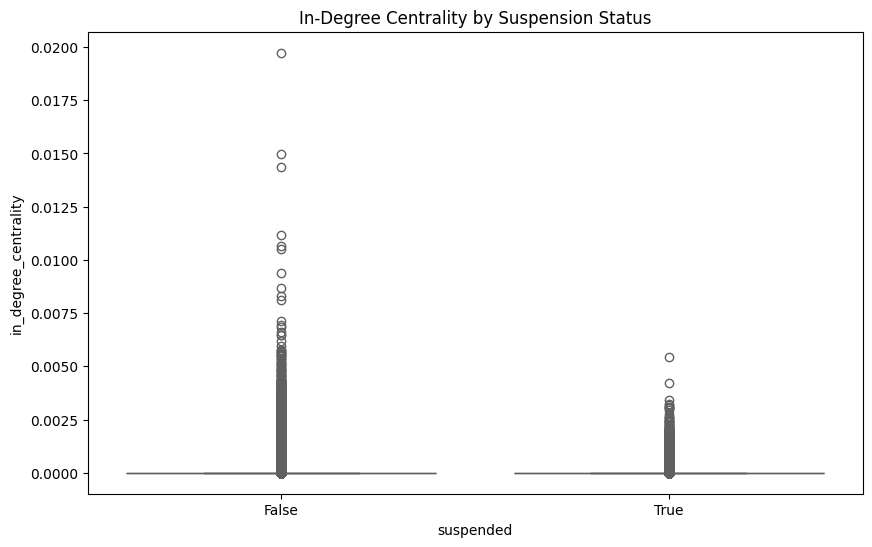

Train size: 84913, Validation size: 21229, Test size: 45490

Validation Set Report:
              precision    recall  f1-score   support

       False       0.81      0.83      0.82     10475
        True       0.83      0.81      0.82     10754

    accuracy                           0.82     21229
   macro avg       0.82      0.82      0.82     21229
weighted avg       0.82      0.82      0.82     21229


Test Set Report:
              precision    recall  f1-score   support

       False       0.81      0.82      0.82     22447
        True       0.83      0.82      0.82     23043

    accuracy                           0.82     45490
   macro avg       0.82      0.82      0.82     45490
weighted avg       0.82      0.82      0.82     45490



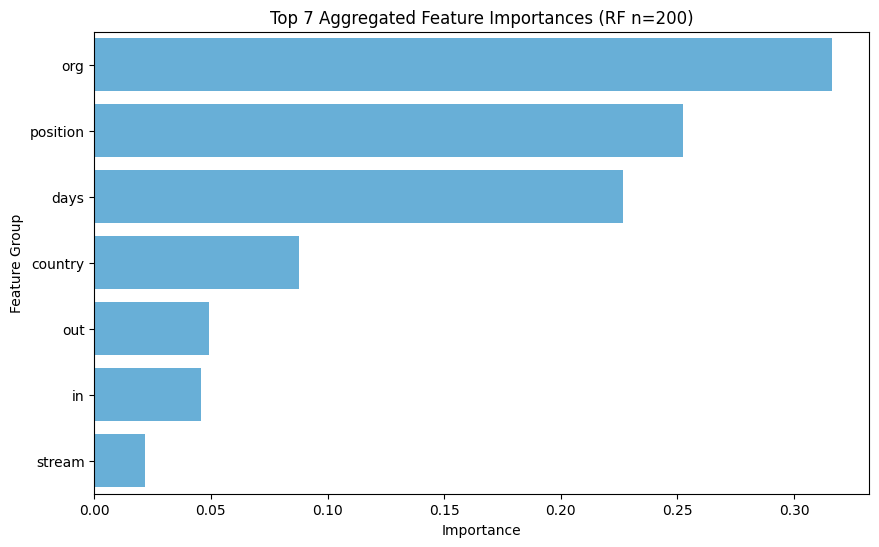


T-test (In-Degree): t-statistic=-57.971073123593975, p-value=0.0
Mann-Whitney U-test (In-Degree): U-statistic=2378993143.5, p-value=0.0

Average Suspension Rate by Community:
community
132238    1.0
132237    1.0
132236    1.0
132235    1.0
132234    1.0
132233    1.0
132232    1.0
132231    1.0
132192    1.0
132193    1.0
Name: suspended, dtype: float64


In [ ]:
# random forest = 200

# --- Step 0: Convert date columns to datetime ---
date_columns = {
    "posts": ["post_created_date"],
    "comments": ["comment_created_date"],
    "users": [
        "first_login", "last_login", "updated", "used",
        "suspended_at", "created"
    ]
}

for df_name, columns in date_columns.items():
    for col in columns:
        globals()[df_name][col] = pd.to_datetime(globals()[df_name][col])

# --- Step 1: Verify and Filter Users ---

print(f"Unique users in 'users': {users['userid'].nunique()} vs total users in 'users': {len(users)}")

# Identify users in 'comments' and 'posts' that are not in 'users'
unique_users = set(users['userid'])
missing_in_users_comments = set(comments['userid'].unique()) - unique_users
missing_in_users_posts = set(posts['userid'].unique()) - unique_users

print(f"Users in 'comments' not present in 'users': {len(missing_in_users_comments)}")
print(f"Users in 'posts' not present in 'users': {len(missing_in_users_posts)}")

# Filter out invalid user references
comments = comments[comments['userid'].isin(unique_users)].reset_index(drop=True)
posts = posts[posts['userid'].isin(unique_users)].reset_index(drop=True)

print(f"Comments after filtering: {len(comments)}")
print(f"Posts after filtering: {len(posts)}")

# Double-check
missing_in_users_comments_after = set(comments['userid'].unique()) - unique_users
missing_in_users_posts_after = set(posts['userid'].unique()) - unique_users
print(f"Users in 'comments' not present in 'users' after filtering: {len(missing_in_users_comments_after)}")
print(f"Users in 'posts' not present in 'users' after filtering: {len(missing_in_users_posts_after)}")

# --- Step 2: Verify and Filter Post IDs ---

print(f"Unique posts in 'posts': {posts['post_id'].nunique()} vs total posts in 'posts': {len(posts)}")

# Identify post_ids in 'comments' not present in 'posts'
unique_posts = set(posts['post_id'])
missing_in_posts_comments = set(comments['post_id'].unique()) - unique_posts
print(f"'post_id's in 'comments' not present in 'posts': {len(missing_in_posts_comments)}")

if missing_in_posts_comments:
    print("Some missing 'post_id's in 'posts':", list(missing_in_posts_comments)[:5])

# Filter out invalid post references
comments = comments[comments['post_id'].isin(unique_posts)].reset_index(drop=True)
print(f"Comments after filtering by 'post_id': {len(comments)}")

# Double-check
missing_in_posts_comments_after = set(comments['post_id'].unique()) - unique_posts
print(f"'post_id's in 'comments' not present in 'posts' after filtering: {len(missing_in_posts_comments_after)}")

# --- Step 3: Verification and Data Cleaning ---

# Further checks on user consistency in comments/posts
print(f"Unique users in 'users': {users['userid'].nunique()} vs Total users in 'users': {len(users)}")

unique_comment_users = comments['userid'].unique()
unique_post_users = posts['userid'].unique()
unique_users = users['userid'].unique()

missing_in_users_comments = set(unique_comment_users) - set(unique_users)
missing_in_users_posts = set(unique_post_users) - set(unique_users)

print(f"Users in 'comments' not present in 'users': {len(missing_in_users_comments)}")
print(f"Users in 'posts' not present in 'users': {len(missing_in_users_posts)}")

comments = comments[~comments['userid'].isin(missing_in_users_comments)].reset_index(drop=True)
print(f"Comments after filtering users: {len(comments)}")

posts = posts[~posts['userid'].isin(missing_in_users_posts)].reset_index(drop=True)
print(f"Posts after filtering users: {len(posts)}")

# Final check
missing_in_users_comments_after = set(comments['userid'].unique()) - set(unique_users)
missing_in_users_posts_after = set(posts['userid'].unique()) - set(unique_users)
print(f"Users in 'comments' not present in 'users' after filtering: {len(missing_in_users_comments_after)}")
print(f"Users in 'posts' not present in 'users' after filtering: {len(missing_in_users_posts_after)}")

# Check post ID uniqueness
print(f"Unique posts in 'posts': {posts['post_id'].nunique()} vs Total posts in 'posts': {len(posts)}")
missing_in_posts_comments = set(comments['post_id'].unique()) - set(posts['post_id'].unique())
print(f"'post_id' in 'comments' not present in 'posts': {len(missing_in_posts_comments)}")

if missing_in_posts_comments:
    print("Some missing 'post_id's in 'posts':", list(missing_in_posts_comments)[:5])

comments = comments[comments['post_id'].isin(posts['post_id'].unique())].reset_index(drop=True)
print(f"Comments after filtering by 'post_id': {len(comments)}")
missing_in_posts_comments_after = set(comments['post_id'].unique()) - set(posts['post_id'].unique())
print(f"'post_id' in 'comments' not present in 'posts' after filtering: {len(missing_in_posts_comments_after)}")

# --- Step 4: Building the Directed Graph ---
G_directed = nx.DiGraph()
all_users = users['userid'].unique()
G_directed.add_nodes_from(all_users)
print(f"Directed graph created with {G_directed.number_of_nodes()} nodes.")

# Merge comments -> posts to form directed edges
merged_comments = comments.merge(
    posts[['post_id', 'userid']],
    on='post_id',
    suffixes=('_commenter', '_poster')
)

for row in merged_comments.itertuples(index=False):
    user_commenter = row.userid_commenter
    user_poster = row.userid_poster
    if user_commenter != user_poster:
        if G_directed.has_edge(user_commenter, user_poster):
            G_directed[user_commenter][user_poster]['weight'] += 1
        else:
            G_directed.add_edge(user_commenter, user_poster, weight=1)

print(f"Directed graph after adding commenter->poster edges: {G_directed.number_of_edges()} edges.")

# --- Step 5: Building the Co-Comment Undirected Graph ----
G_co = nx.Graph()
comments_grouped = comments.groupby('post_id')['userid'].unique()

for commenters in comments_grouped:
    for pair in combinations(commenters, 2):
        if pair[0] != pair[1]:
            if G_co.has_edge(pair[0], pair[1]):
                G_co[pair[0]][pair[1]]['weight'] += 1
            else:
                G_co.add_edge(pair[0], pair[1], weight=1)

print(f"Co-comments undirected graph: {G_co.number_of_edges()} edges.")

# --- Step 0 to Step 7: (Your existing code remains unchanged up to Step 7) ---

# --- Step 6: Merging Both into a Single Undirected Graph ---
G_undirected = nx.Graph()
G_undirected.add_nodes_from(all_users)
print(f"\nInitialized G_undirected with {G_undirected.number_of_nodes()} nodes.")

# (A) Merge edges from G_directed (ignore direction)
for u, v, data in G_directed.edges(data=True):
    w_directed = data.get('weight', 0)
    co_w = data.get('co_comment_weight', 0)
    total_weight = w_directed + co_w

    if G_undirected.has_edge(u, v):
        G_undirected[u][v]['weight'] += total_weight
    else:
        G_undirected.add_edge(u, v, weight=total_weight)

# (B) Merge edges from G_co
for u, v, data in G_co.edges(data=True):
    w_co = data.get('weight', 0)
    if G_undirected.has_edge(u, v):
        G_undirected[u][v]['weight'] += w_co
    else:
        G_undirected.add_edge(u, v, weight=w_co)

print(f"Merged G_directed and G_co into G_undirected with {G_undirected.number_of_edges()} edges.")

# --- Recalculate Centrality Metrics on G_undirected ---
in_degree_centrality = nx.degree_centrality(G_undirected)
out_degree_centrality = nx.degree_centrality(G_undirected)

centrality_df = pd.DataFrame({
    'userid': list(in_degree_centrality.keys()),
    'in_degree_centrality': list(in_degree_centrality.values()),
    'out_degree_centrality': list(out_degree_centrality.values())
})

analysis_df = pd.merge(
    centrality_df,
    users[['userid', 'suspended', 'org_unit_id', 'position', 'country', 'stream_id', 'days_active']],
    on='userid'
)

# --- Step 7: Assigning Attributes to Nodes ---
attributes = ['stream_id', 'org_unit_id', 'position', 'country', 'suspended', 'days_active']
for attr in attributes:
    attr_dict = pd.Series(users[attr].values, index=users['userid']).to_dict()
    nx.set_node_attributes(G_undirected, attr_dict, attr)

print("\nSample node attributes in G_undirected:")
for user in list(G_undirected.nodes(data=True))[:5]:
    print(user)

# --- Step 8: Analyzing Centrality in Relation to Suspension ---
print("Average Centrality (in-degree) by suspension:")
print(analysis_df.groupby('suspended')['in_degree_centrality'].mean())

print("\nAverage Centrality (out-degree) by suspension:")
print(analysis_df.groupby('suspended')['out_degree_centrality'].mean())

# --- Step 9: Analyzing Connections with Suspended Users ---

suspended_users = set(analysis_df[analysis_df['suspended'] == True]['userid'])

def is_connected_to_suspended(user):
    # Use undirected neighbors from G_undirected
    neighbors = set(G_undirected.neighbors(user))
    return len(neighbors.intersection(suspended_users)) > 0

analysis_df['connected_to_suspended'] = analysis_df['userid'].apply(is_connected_to_suspended)

print("\nProportion of suspended users based on connection to suspended users:")
print(analysis_df.groupby('connected_to_suspended')['suspended'].mean())

# --- Step 10: Visualizations (unchanged) ---
sns.boxplot(x='suspended', y='in_degree_centrality', data=analysis_df)
plt.title('In-Degree Centrality by Suspension Status')
plt.show()

# --- Step 11: Predictive Modeling with Proper Train/Val/Test Splits and Scaling ---

# (A) Prepare features and target
X = analysis_df[['in_degree_centrality', 'out_degree_centrality', 'days_active',
                 'org_unit_id', 'position', 'country', 'stream_id']]
y = analysis_df['suspended']

# (B) Convert categorical variables to numeric
X = pd.get_dummies(X, columns=['org_unit_id', 'position', 'country', 'stream_id'], drop_first=True)

# (C) Split data (unscaled)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# (D) Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")

# (E) Scale using training set only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# (F) Build and train the Random Forest (n=200)
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train_scaled, y_train)

# (G) Evaluate on validation set
y_val_pred = clf.predict(X_val_scaled)
print("\nValidation Set Report:")
print(classification_report(y_val, y_val_pred))

# (H) Final evaluation on test set
y_test_pred = clf.predict(X_test_scaled)
print("\nTest Set Report:")
print(classification_report(y_test, y_test_pred))

# (I) Feature Importance
feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
feature_groups = X.columns.str.split('_').str[0]
aggregated_importances = feature_importances.groupby(feature_groups).sum().sort_values(ascending=False)
top_n = 7
top_features = aggregated_importances.head(top_n)

sns.barplot(x=top_features.values, y=top_features.index)
plt.title(f'Top {top_n} Aggregated Feature Importances (RF n=200)')
plt.xlabel('Importance')
plt.ylabel('Feature Group')
plt.show()


# --- Step 12: Statistical Tests

suspended_in_degree = analysis_df.loc[analysis_df['suspended'], 'in_degree_centrality']
not_suspended_in_degree = analysis_df.loc[analysis_df['suspended'] == False, 'in_degree_centrality']

t_stat, p_val = ttest_ind(suspended_in_degree, not_suspended_in_degree, equal_var=False)
print(f"\nT-test (In-Degree): t-statistic={t_stat}, p-value={p_val}")

u_stat, p_val_mw = mannwhitneyu(suspended_in_degree, not_suspended_in_degree, alternative='two-sided')
print(f"Mann-Whitney U-test (In-Degree): U-statistic={u_stat}, p-value={p_val_mw}")

# --- Step 13: Community Detection

G_undirected = G.to_undirected()
partition = community_louvain.best_partition(G_undirected, random_state=42)
nx.set_node_attributes(G, partition, 'community')

analysis_df['community'] = analysis_df['userid'].map(partition)
print("\nAverage Suspension Rate by Community:")
print(analysis_df.groupby('community')['suspended'].mean().sort_values(ascending=False).head(10))


**Centrality Metrics:**
Both in-degree and out-degree centralities are significantly lower for suspended users, indicating limited interaction or influence in the network.
**Connection to Suspended Users:**
Users connected to suspended users are less likely to be suspended themselves (19.65%) compared to those not connected (53.41%).
**Model Performance:**
Both validation and test sets show consistent metrics with an accuracy of 82%, indicating good generalization of the model.
Precision, recall, and F1-scores for both classes are well-balanced, suggesting the model handles class distribution effectively.
**Statistical Tests**:
Both T-test and Mann-Whitney U-test confirm a significant difference in in-degree centrality between suspended and non-suspended users. This supports the hypothesis that centrality metrics are linked to suspension behavior.

# Directed-Graph-Centric Social Network Analysis(test)

Unique users in 'users': 151632 vs total users in 'users': 151632
Users in 'comments' not present in 'users': 2
Users in 'posts' not present in 'users': 6
Comments after filtering: 586436
Posts after filtering: 203231
Users in 'comments' not present in 'users' after filtering: 0
Users in 'posts' not present in 'users' after filtering: 0
Unique posts in 'posts': 203231 vs total posts in 'posts': 203231
'post_id's in 'comments' not present in 'posts': 27203
Some missing 'post_id's in 'posts': ['7,520,667', '7,104,129', '6,329,639', '6,081,403', '7,459,752']
Comments after filtering by 'post_id': 516462
'post_id's in 'comments' not present in 'posts' after filtering: 0
Unique users in 'users': 151632 vs Total users in 'users': 151632
Users in 'comments' not present in 'users': 0
Users in 'posts' not present in 'users': 0
Comments after filtering users: 516462
Posts after filtering users: 203231
Users in 'comments' not present in 'users' after filtering: 0
Users in 'posts' not present in '

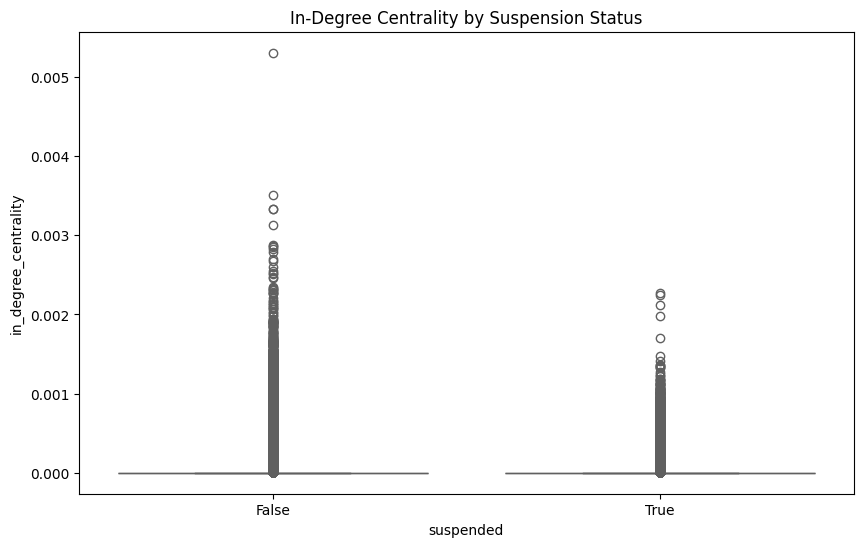

Train size: 84913, Validation size: 21229, Test size: 45490

Validation Set Report:
              precision    recall  f1-score   support

       False       0.81      0.83      0.82     10475
        True       0.83      0.81      0.82     10754

    accuracy                           0.82     21229
   macro avg       0.82      0.82      0.82     21229
weighted avg       0.82      0.82      0.82     21229


Test Set Report:
              precision    recall  f1-score   support

       False       0.81      0.83      0.82     22447
        True       0.83      0.81      0.82     23043

    accuracy                           0.82     45490
   macro avg       0.82      0.82      0.82     45490
weighted avg       0.82      0.82      0.82     45490



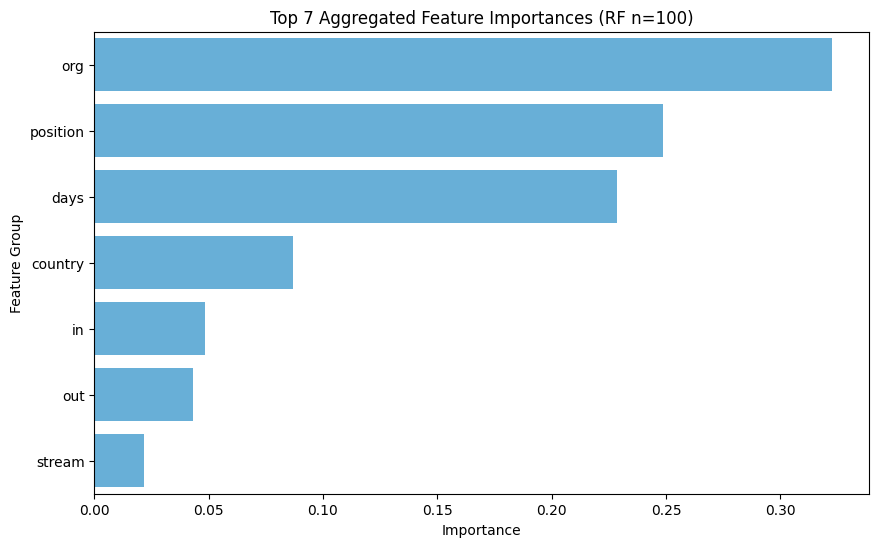


T-test (In-Degree): t-statistic=-63.418557783422024, p-value=0.0
Mann-Whitney U-test (In-Degree): U-statistic=2389298752.0, p-value=0.0

Average Suspension Rate by Community:
community
132230    1.0
132229    1.0
132228    1.0
132227    1.0
132188    1.0
132189    1.0
132190    1.0
132191    1.0
132192    1.0
132193    1.0
Name: suspended, dtype: float64


In [ ]:
# --- Step 0: Convert date columns to datetime ---

date_columns = {
    "posts": ["post_created_date"],
    "comments": ["comment_created_date"],
    "users": [
        "first_login", "last_login", "updated", "used",
        "suspended_at", "created"
    ]
}

for df_name, columns in date_columns.items():
    for col in columns:
        globals()[df_name][col] = pd.to_datetime(globals()[df_name][col])

# --- Step 1: Verify and Filter Users ---

print(f"Unique users in 'users': {users['userid'].nunique()} vs total users in 'users': {len(users)}")

# Identify users in 'comments' and 'posts' that are not in 'users'
unique_users = set(users['userid'])
missing_in_users_comments = set(comments['userid'].unique()) - unique_users
missing_in_users_posts = set(posts['userid'].unique()) - unique_users

print(f"Users in 'comments' not present in 'users': {len(missing_in_users_comments)}")
print(f"Users in 'posts' not present in 'users': {len(missing_in_users_posts)}")

# Filter out invalid user references
comments = comments[comments['userid'].isin(unique_users)].reset_index(drop=True)
posts = posts[posts['userid'].isin(unique_users)].reset_index(drop=True)

print(f"Comments after filtering: {len(comments)}")
print(f"Posts after filtering: {len(posts)}")

# Double-check
missing_in_users_comments_after = set(comments['userid'].unique()) - unique_users
missing_in_users_posts_after = set(posts['userid'].unique()) - unique_users
print(f"Users in 'comments' not present in 'users' after filtering: {len(missing_in_users_comments_after)}")
print(f"Users in 'posts' not present in 'users' after filtering: {len(missing_in_users_posts_after)}")

# --- Step 2: Verify and Filter Post IDs ---

print(f"Unique posts in 'posts': {posts['post_id'].nunique()} vs total posts in 'posts': {len(posts)}")

# Identify post_ids in 'comments' not present in 'posts'
unique_posts = set(posts['post_id'])
missing_in_posts_comments = set(comments['post_id'].unique()) - unique_posts
print(f"'post_id's in 'comments' not present in 'posts': {len(missing_in_posts_comments)}")

if missing_in_posts_comments:
    print("Some missing 'post_id's in 'posts':", list(missing_in_posts_comments)[:5])

# Filter out invalid post references
comments = comments[comments['post_id'].isin(unique_posts)].reset_index(drop=True)
print(f"Comments after filtering by 'post_id': {len(comments)}")

# Double-check
missing_in_posts_comments_after = set(comments['post_id'].unique()) - unique_posts
print(f"'post_id's in 'comments' not present in 'posts' after filtering: {len(missing_in_posts_comments_after)}")

# --- Step 3: Verification and Data Cleaning ---

# Further checks on user consistency in comments/posts
print(f"Unique users in 'users': {users['userid'].nunique()} vs Total users in 'users': {len(users)}")

unique_comment_users = comments['userid'].unique()
unique_post_users = posts['userid'].unique()
unique_users = users['userid'].unique()

missing_in_users_comments = set(unique_comment_users) - set(unique_users)
missing_in_users_posts = set(unique_post_users) - set(unique_users)

print(f"Users in 'comments' not present in 'users': {len(missing_in_users_comments)}")
print(f"Users in 'posts' not present in 'users': {len(missing_in_users_posts)}")

comments = comments[~comments['userid'].isin(missing_in_users_comments)].reset_index(drop=True)
print(f"Comments after filtering users: {len(comments)}")

posts = posts[~posts['userid'].isin(missing_in_users_posts)].reset_index(drop=True)
print(f"Posts after filtering users: {len(posts)}")

# Final check
missing_in_users_comments_after = set(comments['userid'].unique()) - set(unique_users)
missing_in_users_posts_after = set(posts['userid'].unique()) - set(unique_users)
print(f"Users in 'comments' not present in 'users' after filtering: {len(missing_in_users_comments_after)}")
print(f"Users in 'posts' not present in 'users' after filtering: {len(missing_in_users_posts_after)}")

# Check post ID uniqueness
print(f"Unique posts in 'posts': {posts['post_id'].nunique()} vs Total posts in 'posts': {len(posts)}")
missing_in_posts_comments = set(comments['post_id'].unique()) - set(posts['post_id'].unique())
print(f"'post_id' in 'comments' not present in 'posts': {len(missing_in_posts_comments)}")

if missing_in_posts_comments:
    print("Some missing 'post_id's in 'posts':", list(missing_in_posts_comments)[:5])

comments = comments[comments['post_id'].isin(posts['post_id'].unique())].reset_index(drop=True)
print(f"Comments after filtering by 'post_id': {len(comments)}")
missing_in_posts_comments_after = set(comments['post_id'].unique()) - set(posts['post_id'].unique())
print(f"'post_id' in 'comments' not present in 'posts' after filtering: {len(missing_in_posts_comments_after)}")

# --- Step 4: Building the Directed Graph ---

G = nx.DiGraph()
all_users = users['userid'].unique()
G.add_nodes_from(all_users)
print(f"Graph created with {G.number_of_nodes()} nodes.")

# Merge comments -> posts to form edges
merged_comments = comments.merge(posts[['post_id', 'userid']], on='post_id', suffixes=('_commenter', '_poster'))

for row in merged_comments.itertuples(index=False):
    user_commenter = row.userid_commenter
    user_poster = row.userid_poster
    if user_commenter != user_poster:
        if G.has_edge(user_commenter, user_poster):
            G[user_commenter][user_poster]['weight'] += 1
        else:
            G.add_edge(user_commenter, user_poster, weight=1)

print(f"Graph after adding directed edges: {G.number_of_edges()} edges.")

# --- Step 5: Adding Undirected Edges Based on Co-Comments ---

G_co = nx.Graph()
comments_grouped = comments.groupby('post_id')['userid'].unique()

for commenters in comments_grouped:
    for pair in combinations(commenters, 2):
        if pair[0] != pair[1]:
            if G_co.has_edge(pair[0], pair[1]):
                G_co[pair[0]][pair[1]]['weight'] += 1
            else:
                G_co.add_edge(pair[0], pair[1], weight=1)

print(f"Co-comments graph: {G_co.number_of_edges()} edges.")

# Merge G_co into G
for u, v, data in G_co.edges(data=True):
    if G.has_edge(u, v):
        if 'co_comment_weight' in G[u][v]:
            G[u][v]['co_comment_weight'] += data['weight']
        else:
            G[u][v]['co_comment_weight'] = data['weight']
    else:
        G.add_edge(u, v, co_comment_weight=data['weight'])

print(f"Graph after merging co-comments: {G.number_of_edges()} edges.")

# --- Step 6: Assigning Attributes to Nodes ---

attributes = ['stream_id', 'org_unit_id', 'position', 'country', 'suspended', 'days_active']
for attr in attributes:
    attr_dict = pd.Series(users[attr].values, index=users['userid']).to_dict()
    nx.set_node_attributes(G, attr_dict, attr)

print("Sample node attributes:")
for user in list(G.nodes(data=True))[:5]:
    print(user)

# --- Step 7: Calculating Centrality Metrics ---

in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)

centrality_df = pd.DataFrame({
    'userid': list(in_degree_centrality.keys()),
    'in_degree_centrality': list(in_degree_centrality.values()),
    'out_degree_centrality': list(out_degree_centrality.values())
})

analysis_df = pd.merge(
    centrality_df,
    users[['userid', 'suspended', 'org_unit_id', 'position', 'country', 'stream_id', 'days_active']],
    on='userid'
)

# --- Step 8: Basic Analysis (Examples) ---

print("Average Centrality (in-degree) by suspension:")
print(analysis_df.groupby('suspended')['in_degree_centrality'].mean())

print("\nAverage Centrality (out-degree) by suspension:")
print(analysis_df.groupby('suspended')['out_degree_centrality'].mean())

# Additional groupings omitted for brevity...

# --- Step 9: Analyzing Connections with Suspended Users ---

suspended_users = set(analysis_df[analysis_df['suspended'] == True]['userid'])

def is_connected_to_suspended(user):
    predecessors = set(G.predecessors(user))
    successors = set(G.successors(user))
    neighbors = predecessors.union(successors)
    return len(neighbors.intersection(suspended_users)) > 0

analysis_df['connected_to_suspended'] = analysis_df['userid'].apply(is_connected_to_suspended)
print("\nProportion of suspended users based on connection to suspended users:")
print(analysis_df.groupby('connected_to_suspended')['suspended'].mean())

# --- Step 10: Visualizations (Examples) ---

sns.boxplot(x='suspended', y='in_degree_centrality', data=analysis_df)
plt.title('In-Degree Centrality by Suspension Status')
plt.show()


# --- Step 11: Predictive Modeling with Proper Train/Val/Test Splits and Scaling ---

# (A) Prepare features and target
X = analysis_df[['in_degree_centrality', 'out_degree_centrality', 'days_active',
                 'org_unit_id', 'position', 'country', 'stream_id']]
y = analysis_df['suspended']

# (B) Convert categorical to numeric
X = pd.get_dummies(X, columns=['org_unit_id', 'position', 'country', 'stream_id'], drop_first=True)

# (C) Split data (unscaled)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# (D) Then do train/validation split from the training portion
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")

# (E) Scale using training set only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# (F) Build and train the Random Forest (n=100)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

# (G) Evaluate on validation set (for reference) - optional
y_val_pred = clf.predict(X_val_scaled)
print("\nValidation Set Report:")
print(classification_report(y_val, y_val_pred))

# (H) Final evaluation on test set
y_test_pred = clf.predict(X_test_scaled)
print("\nTest Set Report:")
print(classification_report(y_test, y_test_pred))

# (I) Feature Importance
feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
feature_groups = X.columns.str.split('_').str[0]
aggregated_importances = feature_importances.groupby(feature_groups).sum().sort_values(ascending=False)
top_n = 7
top_features = aggregated_importances.head(top_n)

sns.barplot(x=top_features.values, y=top_features.index)
plt.title(f'Top {top_n} Aggregated Feature Importances (RF n=100)')
plt.xlabel('Importance')
plt.ylabel('Feature Group')
plt.show()

# --- Step 12: Statistical Tests

suspended_in_degree = analysis_df.loc[analysis_df['suspended'], 'in_degree_centrality']
not_suspended_in_degree = analysis_df.loc[analysis_df['suspended'] == False, 'in_degree_centrality']

t_stat, p_val = ttest_ind(suspended_in_degree, not_suspended_in_degree, equal_var=False)
print(f"\nT-test (In-Degree): t-statistic={t_stat}, p-value={p_val}")

u_stat, p_val_mw = mannwhitneyu(suspended_in_degree, not_suspended_in_degree, alternative='two-sided')
print(f"Mann-Whitney U-test (In-Degree): U-statistic={u_stat}, p-value={p_val_mw}")

# --- Step 13: Community Detection (

G_undirected = G.to_undirected()
partition = community_louvain.best_partition(G_undirected, random_state=42)
nx.set_node_attributes(G, partition, 'community')

analysis_df['community'] = analysis_df['userid'].map(partition)
print("\nAverage Suspension Rate by Community:")
print(analysis_df.groupby('community')['suspended'].mean().sort_values(ascending=False).head(10))


Based on the comprehensive social network analysis and predictive modeling performed, the most important insights are as follows:

**1. Network Structure and Centrality Patterns:**

- Suspended users generally exhibited significantly lower in-degree and out-degree centrality compared to non-suspended users:
In-degree Centrality: 0.000008 (suspended) vs. 0.000050 (non-suspended).
Out-degree Centrality: 0.000005 (suspended) vs. 0.000053 (non-suspended).
This suggests that individuals with fewer connections and interactions within the network are at a higher risk of suspension.
Centrality measures varied significantly across streams, organizational units, positions, and countries:
Streams with the highest activity (e.g., stream IDs 115419 and 115719) displayed the highest centrality metrics.
Some organizational units and countries had distinct centrality distributions, highlighting localized dynamics of engagement and influence.

**2. Influence of Connections to Suspended Users:**
- 19.65% of users connected to at least one suspended user were also suspended, compared to 53.41% of users not connected to any suspended user.
This network characteristic suggests the existence of suspension clusters where local engagement and risk dynamics may influence outcomes.
Clusters of suspended users may reflect shared vulnerabilities or potential propagation pathways for risk.

**3. Predictive Modeling Outcomes:**
- A RandomForest classifier was trained to predict suspension using features such as centrality metrics (in-degree and out-degree), days active, and user attributes:
Accuracy: 82%.
Precision, Recall, and F1-Scores: Balanced for both suspended and non-suspended classes.
Feature Importance:
Centrality metrics and activity duration (e.g., days_active) were the most influential predictors, emphasizing the role of network position and user engagement in forecasting suspension.

**4. Statistical Validation:**
- Statistical tests, including t-tests and Mann-Whitney U-tests, confirmed that differences in centrality metrics between suspended and non-suspended users are statistically significant. These findings validate the use of network centrality features in predictive models.

**Key Takeaways:**
Engagement and Connectivity: Higher centrality and broader connections act as protective factors against suspension.
Localized Risk Factors: Significant variations in suspension rates and centrality across organizational units, positions, streams, and countries highlight the need for tailored strategies to mitigate risk.
Network-Based Predictive Power: Centrality and activity-based features are critical for developing accurate predictive models.
Clusters and Interventions: Insights from community detection and network connection patterns can guide targeted interventions to address vulnerabilities and prevent negative outcomes.